## Import NBER graph and add department data

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import scipy.stats as stats
import nltk.metrics as nm
import editdistance
import re
import matplotlib.pyplot as plt
execfile("utils.py")
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Begin analysis

In [2]:
# Load merged department-author graph from file
# NBER graph contains coauthorship edges annotated with JEL codes 
path = '../save/authors_departments.graphml'
G = nx.read_graphml(path)

In [9]:
# Get List of JEL codes
e = G.edges(data=True)
jels = getJELs(G)
bigJels = getBigJELs(jels)
print "# of JELs %d" % len(jels)
print "# of big JELs: %d" % len(bigJels)

# Get List of Nodes 
n = G.nodes()
ndf = pd.DataFrame(n, columns=['author'])
print "# of nodes: %d" % len(n)
print "# of pairs of coauthors: %d" % len(G.edges())

# of JELs 145
# of big JELs: 26
# of nodes: 9757
# of pairs of coauthors: 64532


## Summarize a list of subgraphs 

In [25]:
# utility functions

def getExternalDegreeDist(subgraph, graph):
    degs = np.array(nx.degree(graph, subgraph.nodes()).values()) - np.array(nx.degree(subgraph, subgraph.nodes()).values())
    
    return np.histogram(degs, bins=max(degs))[0]

In [26]:
def getAvgExternalDegree(subgraph, graph):
    try: 
        gdegree = np.array(nx.degree(graph, subgraph.nodes()).values())
        sgdegree = np.array(nx.degree(subgraph, subgraph.nodes()).values())
        return np.nanmean(gdegree - sgdegree)
    except:
        return np.nan

In [27]:
def getWithinDegreeDist(subgraph):
    return nx.degree_histogram(subgraph)

In [93]:
# Summarize a set 
# For each graph in a list, compute Avg Degree, Avg Betweenness Centrality, 
# Number of Components,
# Number of Nodes, Longest Shortest Path, Total # of Papers, 
# Avg # of Papers per author, % of Papers within Dept, Rank

# For example, "kind" could be 'Institution', "entries" would be a list of institutions
def summGraphList(kind, entries, subgraphList, graph):
    df = pd.DataFrame()
    df['id']        = entries
    
    df['Subgraph']  = df.id.apply(lambda x: subgraphList[x])
    
    # Drop isolated nodes from subgraphs
    # Note that this drops individuals in the subnetwork who have only external edges
    df['SGNoIsolates'] =  df.Subgraph.apply(lambda x: x.remove_nodes_from(nx.isolates(x)) >>> x.nodes())
    
    df['nNodes'] = df.Subgraph.apply(lambda x: len(x.nodes()))
    
    # Drop empty entries
    df = df[df.nNodes != 0]
    
    df['nTotEdges'] = df.Subgraph.apply(lambda x: len(x.edges())) # number of paper x coauthor pairs within subnetwork
    #df['nExtEdges'] = df.Subgraph.apply(lambda x: len(x.edges()))
        
    # degree distribution within the subnetwork
    df['AvgWithinDeg'] = df.Subgraph.apply(lambda x: \
                                         np.mean(nx.degree(x, x.nodes()).values()))

    df['AvgWithinDegNoIsolates'] = df.SGNoIsolates.apply(lambda x: \
                                         np.mean(nx.degree(x, x.nodes()).values()))
    
    df['WithinDegDist'] = df.SGNoIsolates.apply(lambda x: getWithinDegreeDist(x))
    df['WithinDegSkew'] = df.WithinDegDist.apply(lambda x: stats.skew(x))
    
    # avg degree from within to outside the subnetwork
    df['AvgExternalDegree'] = df.Subgraph.apply(lambda x: getAvgExternalDegree(x, graph))
    df['AvgExtDegNoIsolates'] = df.SGNoIsolates.apply(lambda x: getAvgExternalDegree(x, graph))
    
    df['ExtDegDist'] = df.SGNoIsolates.apply(lambda x: getExternalDegreeDist(x, graph))
    df['ExtDegSkew'] = df.ExtDegDist.apply(lambda x: stats.skew(x))

    # Summary stats for connected components
    df['nConnComp'] = df.SGNoIsolates.apply(lambda x: \
                                   len([c for c in nx.connected_components(x)]))
    df['AvgSizeCC'] = df.SGNoIsolates.apply(lambda x: \
                                         np.mean([len(c) for c in nx.connected_components(x)]))
    df['MaxSizeCC'] = df.SGNoIsolates.apply(lambda x: \
                                         np.max([len(c) for c in nx.connected_components(x)]))
  
    # betweenness - gonna be very computationally intensive
    # df['BetweennessDist'] = df.Graph.apply(lambda x: nx.betweenness_centrality(x))
    
    # clustering coefficients
    df['clusterCoeff'] = df.SGNoIsolates.apply(lambda x: nx.average_clustering(nx.Graph(x)))
        
    # zscore-ify
    for col in ['AvgExternalDegree','WithinDegSkew','clusterCoeff','AvgWithinDeg','ExtDegSkew']:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    
    # rename id column 
    df.rename(columns={'id': kind})
    
    # export to latex
    all_cols     = df.columns
    exclude_cols = ['Subgraph','WithinDegDist','ExtDegDist','SGNoIsolates']
    export_cols  = list(set(all_cols) - set(exclude_cols))
    text = df[export_cols].to_latex(longtable = True, float_format=lambda x: "%.3f" % x)
    fn = "../save/%s_summtable_sub.tex" % kind
    f = open(fn, 'w')
    f.write(text)
    f.close()
    return df

In [ ]:
# how many papers written != # of edges. Must divide # of edges 


## Examine JEL subgraphs

In [86]:
# save coauthorship network for each JEL category
jelGraphs = {}
overwrite = 1
for currCode in bigJels:
    jelGraphs[currCode] = getBigJELSubgraph(G, currCode)
    if overwrite:
        nx.write_graphml(jelGraphs[currCode], '../save/jel' + currCode + '.graphml')

In [94]:
sgl = summGraphList('bigJel', list(bigJels), jelGraphs, G)
#jel = 'A'
#[e for e in G.edges(data=True) if jel in re.findall("[a-zA-Z]", e[2]['jelcode'][0])]

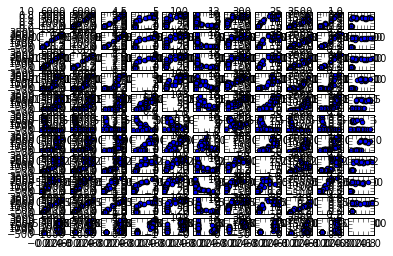

In [34]:
cols = [c for c in sgl.columns if 'id' not in c and 'Subgraph' not in c and 'Dist' not in c]
nCols = len(cols)

fig,ax = plt.subplots(nrows=nCols,ncols=nCols)

for i in range(nCols):
    for j in range(nCols):
        if i == j:
            continue
        else:
            ax[i,j].scatter(sgl[cols[i]], sgl[cols[j]])
            
            

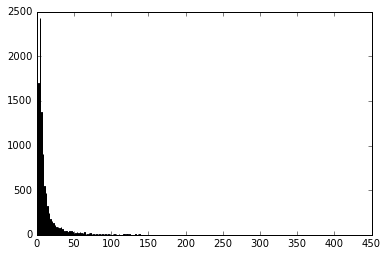

In [35]:
dd = nx.degree_histogram(G) 

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(np.arange(len(dd)),dd)
plt.show()

## Examine institutional subgraphs 

In [4]:
authDept = pd.read_csv('../save/authors_departments_extended.csv', delimiter='|')

In [37]:
# Get list of NBER authors corresponding to Institution

instGraphs = {}
insts = authDept.Institution.unique()

# save coauthorship network for each institution
for currInst in insts:
    instGraphs[currInst] = G.subgraph(list(authDept[authDept.Institution == currInst].author))
    nx.write_graphml(instGraphs[currInst], \
                     '../save/' + currInst.replace(',','').replace(' ','_') + '.graphml')

In [13]:
# authDept.groupby(["Institution"]).first().reset_index()

In [95]:
# Summarize Institutional Graphs
sumInsts = summGraphList('Institution', insts, instGraphs, G)

In [ ]:
NBERPapers = pd.read_csv('../save/NBER_Paper_Info.1.csv', delimiter='|')

## Netflix feature matrix

- Pagerank
- JEL codes
- Geographic location (state, time zone) (prob time zone)
- Department

In [ ]:
# make a JEL lookup table to map jels to indices                                                     
jelLookup = dict()
for i, jel in enumerate(jels):
    jelLookup[jel] = i

# make an array of authors x JELs 
# to count how many papers in each JEL someone has
authors = nx.nodes(G)
authorCodes = np.zeros((len(authors), len(jels)))
for a in range(len(authors)):
    papers = G.edges(authors[a])
    for p in papers:
        paperAttrs = G.get_edge_data(p[0], p[1])
        paperJels  = paperAttrs['jelcode'].split(',')
        jelInds = [jelLookup[jel] for jel in paperJels]
        authorCodes[a, jelInds] += 1

In [ ]:
# PageRanks
ranks = nx.pagerank(G)

# add to graph                                                                  
nx.set_node_attributes(G, 'rank', ranks)

# in case we want to look at the top authors                                    
sortedRanks = sorted(ranks.items(), key=lambda x: x[1])

In [ ]:
# Extract PageRank to a vector                                                  
authors = G.nodes()
nodeRanks = np.empty(len(authors))
for i in range(len(authors)):
    nodeRanks[i] = ranks.get(authors[i])
nodeRanks = np.reshape(nodeRanks, (len(nodeRanks),1))

In [ ]:
# make feature dataframe
data = np.hstack((nodeRanks,authorCodes))
df = pd.DataFrame(data)
df.columns = ['rank'] + [jel for jel in jels]
df['author'] = authors

In [ ]:
df

In [ ]:
G.nodes(1)

#### TODO 

- Aggregate JELs by letter 
- Add JELS as author attributes.
- Look at degree distribution of subgraphs given by each JEL code